# Klasifikasi Ujaran Kebencian (Hate Speech) pada Tweet Indonesia menggunakan Arsitektur RNN

## Anggota Kelompok
1. Zakiyah Hasanah (2305274)
2. Putra Hadiyanto Nugroho (2308163)
3. Hafsah Hamidah (2311474)
4. Natasha Adinda Cantika (2312120)

## Pendahuluan

Fenomena **ujaran kebencian (*Hate Speech*)** di media sosial, khususnya Twitter, telah menjadi tantangan serius dalam menjaga ruang publik yang sehat di Indonesia. Ujaran kebencian merupakan salah satu bentuk **sentimen negatif ekstrem** yang perlu dideteksi dan diklasifikasikan secara otomatis. Tugas utama dalam *Natural Language Processing* (NLP) adalah membangun sistem yang mampu mengidentifikasi dan mengklasifikasikan konten beracun (*toxic content*) tersebut.

*Notebook* ini bertujuan untuk mengimplementasikan dan membandingkan kinerja arsitektur *Deep Learning* berbasis *Recurrent Neural Network* (RNN) yaitu **SimpleRNN**, **LSTM**, dan **Bidirectional LSTM** dalam tugas **klasifikasi biner** untuk mendeteksi ujaran kebencian pada teks berbahasa Indonesia. Arsitektur RNN, termasuk LSTM, sangat relevan untuk tugas sekuensial seperti teks karena kemampuannya dalam memproses urutan kata dan menangkap ketergantungan konteks, yang krusial dalam membedakan sentimen negatif biasa dengan ujaran kebencian.

## Deskripsi

Implementasi dalam *notebook* ini meliputi langkah-langkah kritis, mulai dari pemuatan dan pembersihan data hingga pelatihan model *Deep Learning* tingkat lanjut.

1.  **Preprocessing Mendalam:** Melakukan pembersihan teks (hapus *noise*, *case folding*), normalisasi kata alay menggunakan kamus kustom, dan penghapusan *stopwords* spesifik bahasa Indonesia.
2.  **Visualisasi & Eksplorasi Data:** Menganalisis distribusi kelas dan kata-kata dominan (*Word Clouds*) untuk memastikan kualitas dan keseimbangan data.
3.  **Modeling:** Membangun dan melatih model SimpleRNN, LSTM, dan Bidirectional LSTM.
4.  **Evaluasi:** Membandingkan ketiga model menggunakan metrik akurasi, *precision*, *recall*, dan *F1-Score* untuk menentukan arsitektur terbaik dalam mendeteksi *hate speech*.

## Dataset dan Sumber Data

Dataset yang digunakan untuk proyek ini adalah dataset *Multi-label Hate Speech and Abusive Language* Twitter berbahasa Indonesia yang bersifat multitopik. Dataset ini telah diperkaya dengan berbagai label untuk memudahkan klasifikasi.

### Label Utama
* **HS (Hate Speech):** **1** untuk tweet yang mengandung *hate speech*, **0** untuk tweet yang **Non-Hate Speech**.
* **Abusive:** Label untuk tweet yang mengandung bahasa kasar.
* **HS\_Individual, HS\_Group, HS\_Religion, dll:** Label spesifik untuk tipe *hate speech*.

Dataset juga dilengkapi dengan kamus normalisasi (`new_kamusalay.csv`) untuk menormalkan kata-kata tidak baku (alay).

### Sumber Data dan Sitasi
* **Tautan Data:** [https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text](https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text)
* **Sitasi Akademik:**
    > Muhammad Okky Ibrohim and Indra Budi. 2019. **Multi-label Hate Speech and Abusive Language Detection in Indonesian Twitter**. In ALW3: 3rd Workshop on Abusive Language Online, 46-57.

## Analisis Data dan Preprocessing

### 1. Tahap Persiapan Data
Sebelum melakukan analisis, kita perlu mempersiapkan environment dan data:
- Import library yang diperlukan (pandas, numpy, nltk, dll.)
- Mengunduh resource NLTK untuk tokenisasi

#### Import Library
Mari kita import library-library yang diperlukan untuk analisis data, preprocessing text, deep learning, dan visualisasi.

In [1]:
pip install --upgrade matplotlib matplotlib-inline ipython


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk wordcloud Pillow tqdm


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import nltk

# Import library Deep Learning dan Sklearn (untuk bagian modeling)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tqdm.notebook import tqdm
from collections import Counter # Untuk Top Words

# Download NLTK data (Jika belum ada)
print("Downloading NLTK data...")
nltk.download('punkt', quiet=True)
print("Download completed!")

2025-11-07 03:17:31.005657: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 03:17:31.042914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-07 03:17:31.043091: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-07 03:17:31.044514: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-07 03:17:31.052980: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-07 03:17:31.053951: I tensorflow/core/platform/cpu_feature_guard.cc:1

### 2. Preprocessing Text
Tahapan preprocessing yang akan dilakukan:
- Case folding (lowercase)
- Pembersihan tweet (menghapus @user, URL, simbol)
- Normalisasi kata menggunakan kamus alay
- Tokenisasi dan penghapusan stopwords
- Penanganan encoding untuk file dataset

#### Load Dataset dan Kamus
Kita akan memuat dataset hate speech dan kamus normalisasi bahasa alay. Dataset terdiri dari tweet berbahasa Indonesia dengan label hate speech, sedangkan kamus normalisasi berisi mapping dari kata tidak baku ke kata baku.

In [4]:
# Definisi stopwords Bahasa Indonesia
all_stopwords_list = [
    'yang', 'di', 'ke', 'dari', 'pada', 'dalam', 'untuk', 'dengan', 'dan', 'atau',
    'ini', 'itu', 'juga', 'sudah', 'saya', 'aku', 'kamu', 'dia', 'mereka',
    'kita', 'akan', 'bisa', 'ada', 'tidak', 'saat', 'oleh', 'setelah', 'tentang',
    'seperti', 'ketika', 'bagi', 'sampai', 'karena', 'jika', 'namun', 'sebuah',
    'tersebut', 'lain', 'sekarang', 'sambil', 'yakni', 'selama', 'serta', 'apabila',
    'rt', 'user', 'url', 'xf', 'r', 'pengguna', 'gue', 'sama', 'saja', 'ya', 
    'jadi', 'n', 'xf0', 'x9f', 'x98', 'aja', 'nih', 'deh', 'dong', 'sih', 'loe', 
    'tapi', 'apa', 'adalah', 'tak', 'kalau', 'nya', 'pak', 'mau', 'lagi', 'bukan', 
    'lebih', 'uniform', 'resource', 'locator', 'provider_name', 'face', 'orang', 
    'agama', 'banyak', 'banget', 'memang', 'kayak', 'jangan'
]

indonesian_stopwords = set(all_stopwords_list)

# Fungsi penanganan encoding CSV
def load_csv_with_encoding(filepath, **kwargs):
    encodings = ['utf-8', 'latin1', 'iso-8859-1']
    for encoding in encodings:
        try:
            return pd.read_csv(filepath, encoding=encoding, **kwargs)
        except UnicodeDecodeError:
            continue
    raise ValueError(f"Could not read file {filepath} with any of the encodings: {encodings}")

# Load dataset dan kamus
print("Loading datasets...")
data = load_csv_with_encoding('data_hate_speech.csv')
kamus_alay = load_csv_with_encoding('new_kamusalay.csv', names=['alay', 'normal'])
kamus_alay_dict = dict(zip(kamus_alay['alay'], kamus_alay['normal']))

# --- Penyesuaian Kolom (PENTING untuk visualisasi Seaborn) ---
# Asumsi: Kolom 'HS' (1=Hate Speech/Negative, 0=Non-Hate Speech/Positive)
data['Sentiment'] = data['HS'].apply(lambda x: 'negative' if x == 1 else 'positive')
data['Source'] = 'Twitter Dataset' # Placeholder, sesuaikan jika ada kolom sumber

# Tampilkan informasi dasar
print("\nInformasi Dataset:")
print(data.info())
print("\nDistribusi label Hate Speech:")
print(data['HS'].value_counts())
print("\nSample data:")
print(data[['Tweet', 'HS', 'Sentiment']].head())

Loading datasets...

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
 13  Sentiment      13169 non-null  object
 14  Source         13169 non-null  object
dtypes: int64(12), object(3)
memory usage: 1.5+ MB
None

Distribusi label Hate Speech:
HS
0    7608
1    5561
Name: coun

### 3. Eksplorasi Data
Analisis awal yang akan dilakukan:
- Memeriksa distribusi label HS (Hate Speech)
- Menganalisis karakteristik tweet
- Visualisasi data menggunakan word cloud
- Analisis statistik dasar dataset


--- Pengecekan Kualitas Data Mentah ---
Total baris awal: 13169
⚠️ Ditemukan baris duplikat (berdasarkan 'Tweet'): 146. Akan ditangani jika diperlukan.

--- Top 20 Kata Paling Umum di Dataset (Mentah) ---
        Kata  Jumlah
0       user   16323
1         yg    2952
2        dan    2758
3         di    2733
4        xf0    2109
5        x9f    2094
6       yang    2011
7          n    1754
8        itu    1715
9        x98    1636
10       ini    1585
11       ada    1357
12        rt     964
13        ya     960
14     orang     943
15    jokowi     941
16  presiden     877
17      jadi     832
18       aja     831
19      dari     822

--- Visualisasi Distribusi Sentimen ---


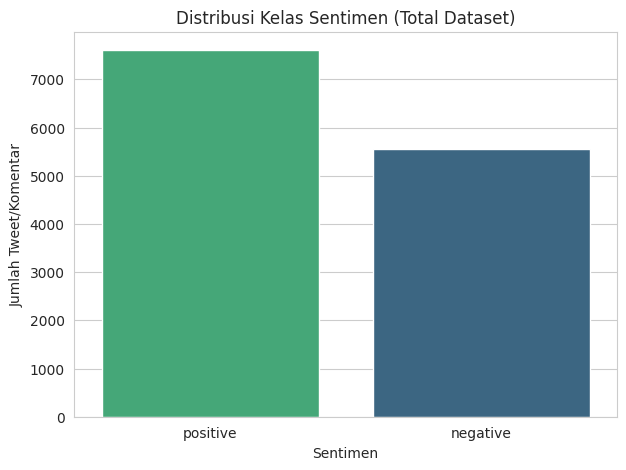


Visualisasi Distribusi Sentimen Berdasarkan Sumber dilewati (Hanya ada satu sumber data).


In [5]:
from collections import Counter
import pandas as pd
import re # Diperlukan untuk clean_and_tokenize_raw
import seaborn as sns
import matplotlib.pyplot as plt

# --- Pengecekan Duplikat Data  ---
initial_rows = len(data)
duplicate_rows = data.duplicated(subset=['Tweet']).sum()

print("\n--- Pengecekan Kualitas Data Mentah ---")
print(f"Total baris awal: {initial_rows}")
if duplicate_rows > 0:
    print(f"⚠️ Ditemukan baris duplikat (berdasarkan 'Tweet'): {duplicate_rows}. Akan ditangani jika diperlukan.")
else:
    print("✅ Tidak ditemukan baris duplikat.")
# ----------------------------------------------------


# --- 3.1 Analisis Top Words (Menggantikan Statistik Panjang Teks) ---

# Pembersihan dasar (hanya untuk menghitung frekuensi kata mentah)
def clean_and_tokenize_raw(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'[^\w\s]', ' ', text) # Ganti tanda baca dengan spasi
    text = re.sub(r'\s+', ' ', text).strip() # Hapus spasi ganda
    return text.split()

# Ambil semua kata dan hitung frekuensi
all_words_raw = []
for tweet in data['Tweet']:
    all_words_raw.extend(clean_and_tokenize_raw(tweet))
    
word_counts_raw = Counter(all_words_raw)
top_words_raw_df = pd.DataFrame(word_counts_raw.most_common(20), columns=['Kata', 'Jumlah'])

print("\n--- Top 20 Kata Paling Umum di Dataset (Mentah) ---")
print(top_words_raw_df)


# --- 3.2 Countplot Sentimen ---
sns.set_style("whitegrid")
print("\n--- Visualisasi Distribusi Sentimen ---")

# Visualisasi 1: Distribusi Sentimen Total
plt.figure(figsize=(7, 5))
sns.countplot(x='Sentiment', data=data, hue='Sentiment', 
              order=data['Sentiment'].value_counts().index, palette="viridis", legend=False)
plt.title('Distribusi Kelas Sentimen (Total Dataset)')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Tweet/Komentar')
plt.show()

# Visualisasi 2: Distribusi Sentimen Berdasarkan Sumber (Hanya efektif jika ada berbagai sumber)
if len(data['Source'].unique()) > 1:
    plt.figure(figsize=(12, 6))
    sns.countplot(x='Source', hue='Sentiment', data=data, palette="Pastel1")
    plt.title('Distribusi Sentimen Berdasarkan Sumber Data')
    plt.xlabel('Sumber Data')
    plt.ylabel('Jumlah Baris')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("\nVisualisasi Distribusi Sentimen Berdasarkan Sumber dilewati (Hanya ada satu sumber data).")

#### Text Preprocessing
Implementasi fungsi preprocessing untuk membersihkan dan menormalisasi teks tweet:
1. Case folding (mengubah ke lowercase)
2. Menghapus username dan URL
3. Menghapus karakter khusus dan angka
4. Normalisasi kata menggunakan kamus alay
5. Tokenisasi
6. Menghapus stopwords

In [6]:
import re
from nltk.tokenize import word_tokenize
# Asumsi: kamus_alay_dict, indonesian_stopwords, dan data sudah terdefinisi dari Cell 2

def preprocess_text(text):
    # Pastikan input adalah string
    text = str(text)
    
    # Case folding (Mengubah ke huruf kecil)
    text = text.lower()
    
    # --- Tambahan Kritis untuk Menghilangkan Sisa URL (Agresif) ---
    # Menghapus token sisa URL secara literal sebelum regex umum
    text = text.replace('uniform resource locator', '') 
    text = text.replace('uniform resource', '') 
    text = text.replace('locator', '') 
    # -----------------------------------------------------------
    
    # Hapus URL (Regex)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Hapus username
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    try:
        # Tokenisasi
        words = word_tokenize(text)
    except Exception as e:
        # Fallback jika ada error tokenisasi
        # print(f"Error in tokenization: {e}") 
        words = text.split() 
    
    # Normalisasi kata menggunakan kamus alay (Penting dilakukan sebelum stopword removal)
    words = [kamus_alay_dict.get(word, word) for word in words]
    
    # Hapus stopwords (Termasuk noise yang sudah ditambahkan ke set)
    words = [word for word in words if word not in indonesian_stopwords]
    
    # Gabungkan kembali
    return ' '.join(words)

# --- PENANGANAN DUPLIKAT (DISISIPKAN DI SINI) ---
initial_rows = len(data)
duplicate_rows = data.duplicated(subset=['Tweet']).sum()

if duplicate_rows > 0:
    print(f"⚠️ Ditemukan {duplicate_rows} baris duplikat. Menghapus duplikat...")
    # Hapus duplikat berdasarkan kolom 'Tweet'
    data.drop_duplicates(subset=['Tweet'], keep='first', inplace=True)
    print(f"Penghapusan duplikat selesai. Sisa baris: {len(data)}")
else:
    print("✅ Tidak ditemukan duplikat untuk dihapus.")
# -----------------------------------------------

# Terapkan preprocessing
print("\nMemulai preprocessing data pada data unik...")
data['processed_text'] = data['Tweet'].apply(lambda x: preprocess_text(x))
print("Preprocessing selesai!")

# Tampilkan contoh hasil preprocessing
print("\nContoh hasil preprocessing:")
for i in range(3):
    print(f"\nTeks asli: {data['Tweet'].iloc[i]}")
    print(f"Hasil preprocessing: {data['processed_text'].iloc[i]}")

⚠️ Ditemukan 146 baris duplikat. Menghapus duplikat...
Penghapusan duplikat selesai. Sisa baris: 13023

Memulai preprocessing data pada data unik...
Preprocessing selesai!

Contoh hasil preprocessing:

Teks asli: - disaat semua cowok berusaha melacak perhatian gue. loe lantas remehkan perhatian yg gue kasih khusus ke elo. basic elo cowok bego ! ! !'
Hasil preprocessing: di saat semua cowok berusaha melacak perhatian lantas remehkan perhatian kasih khusus basic cowok bego

Teks asli: RT USER: USER siapa yang telat ngasih tau elu?edan sarap gue bergaul dengan cigax jifla calis sama siapa noh licew juga'
Hasil preprocessing: siapa telat memberi tau eluedan sarap bergaul cigax jifla calis siapa licew

Teks asli: 41. Kadang aku berfikir, kenapa aku tetap percaya pada Tuhan padahal aku selalu jatuh berkali-kali. Kadang aku merasa Tuhan itu ninggalkan aku sendirian. Ketika orangtuaku berencana berpisah, ketika kakakku lebih memilih jadi Kristen. Ketika aku anak ter
Hasil preprocessing: kadang

#### Visualisasi Setelah Preprocessing Text
Membuat Word Cloud menggunakan data yang sudah bersih (processed_text).


--- Visualisasi Word Clouds (Top 10 Kata) ---
Generating Word Cloud for 'Word Cloud - Hate Speech (HS=1)' (Top 10 Words)...

--- Top 10 Kata untuk 'Word Cloud - Hate Speech (HS=1)' ---
        Kata  Frekuensi
0  indonesia        802
1     jokowi        686
2   presiden        669
3    uniform        498
4   resource        498
5    locator        498
6     cebong        471
7    komunis        437
8     partai        436
9      islam        401

Generating Word Cloud for 'Word Cloud - Hate Speech (HS=1)' (Top 10 Words)...


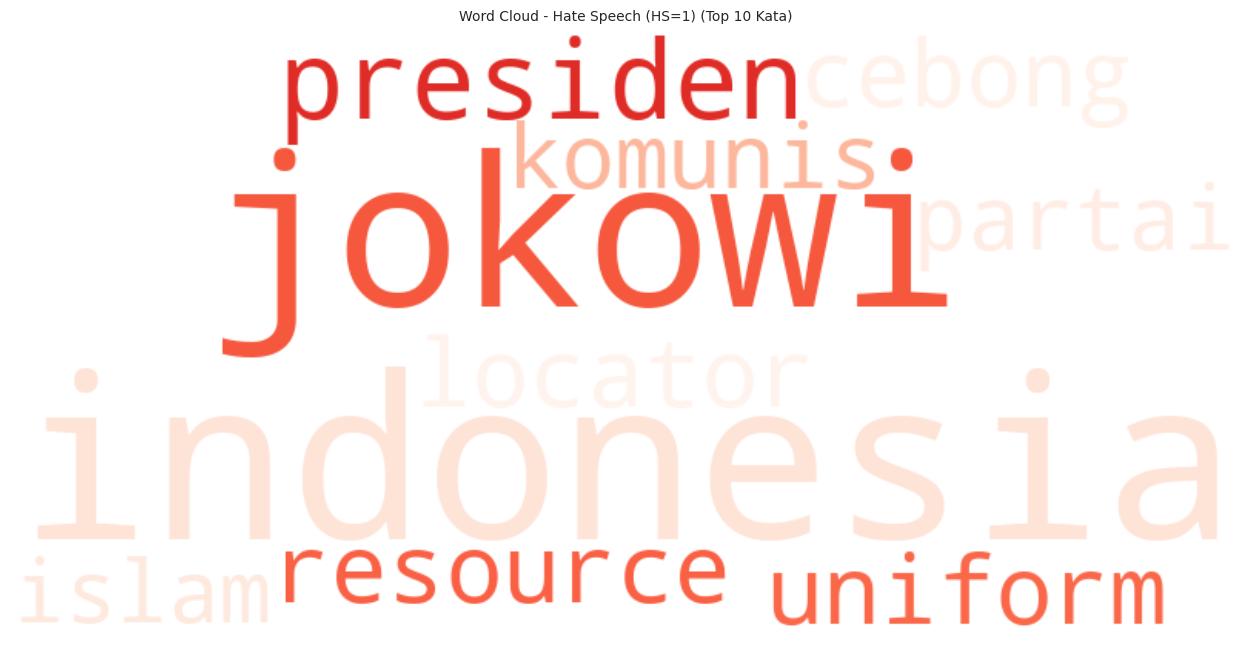

Generating Word Cloud for 'Word Cloud - Non-Hate Speech (HS=0)' (Top 10 Words)...

--- Top 10 Kata untuk 'Word Cloud - Non-Hate Speech (HS=0)' ---
        Kata  Frekuensi
0  indonesia        740
1   presiden        707
2      asing        456
3      islam        420
4     daerah        406
5     jokowi        363
6   gubernur        332
7     kepala        323
8    kristen        310
9    uniform        304

Generating Word Cloud for 'Word Cloud - Non-Hate Speech (HS=0)' (Top 10 Words)...


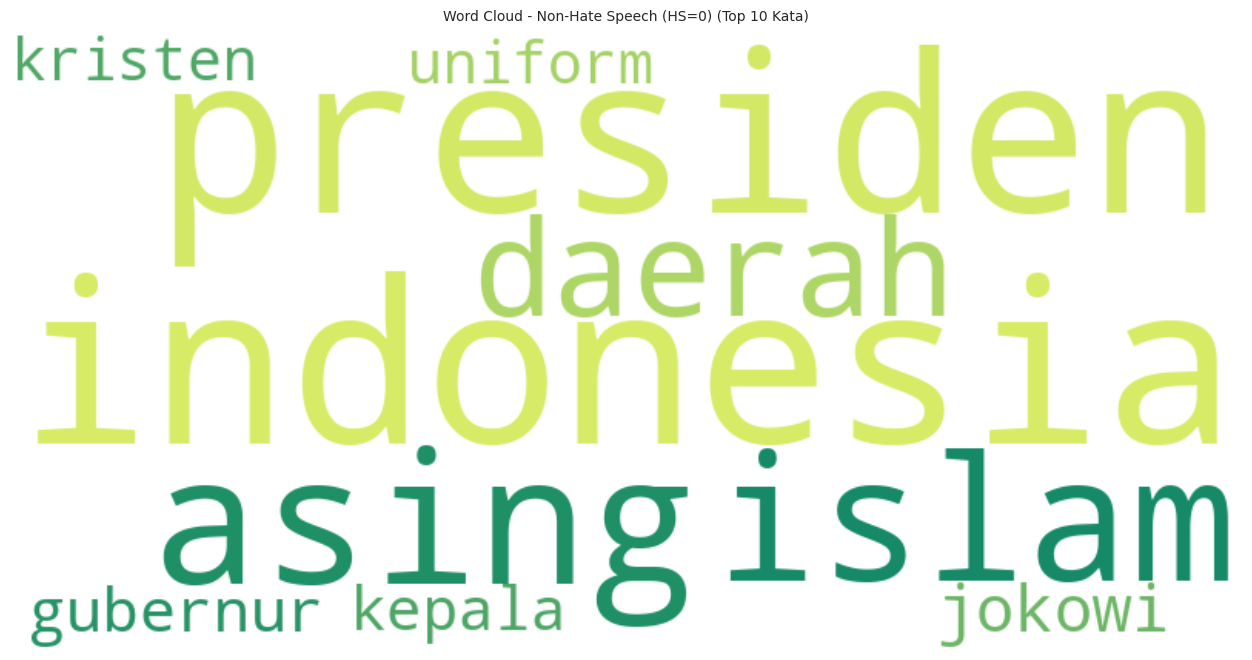


Visualisasi Word Cloud selesai.


In [7]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# Asumsi 'data' sudah dimuat dan memiliki kolom 'HS' dan 'processed_text'

# --- Definisi Fungsi Generate WordCloud Standar (Dimodifikasi untuk Top N) ---

def generate_wordcloud_top_n(text, title, top_n=10, colormap='viridis'):
    """
    Menghasilkan WordCloud persegi standar yang hanya menampilkan N kata teratas 
    dan mencetak daftar kata-kata tersebut.
    """
    print(f"Generating Word Cloud for '{title}' (Top {top_n} Words)...")
    
    # 1. Tokenisasi Teks
    words = text.split()
    
    # 2. Hitung Frekuensi Kata
    word_counts = Counter(words)
    
    # 3. Ambil N Kata Teratas (List of tuples)
    # --- PERBAIKAN: Definisi top_words_list ---
    top_words_list = word_counts.most_common(top_n) 
    top_words_dict = dict(top_words_list) # Konversi ke dictionary untuk WordCloud

    
    print(f"\n--- Top {top_n} Kata untuk '{title}' ---")
    
    # Cetak Daftar Top Words menggunakan list yang benar
    top_words_df = pd.DataFrame(top_words_list, columns=['Kata', 'Frekuensi'])
    print(top_words_df)
    
    print(f"\nGenerating Word Cloud for '{title}' (Top {top_n} Words)...")
    # 4. Inisialisasi WordCloud standar
    wc = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colormap,
        min_font_size=10,
        max_font_size=150
    )
        
    # 5. Generate dari Frekuensi, bukan dari string teks penuh
    wordcloud = wc.generate_from_frequencies(top_words_dict)
    
    # Tampilkan gambar
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{title} (Top {top_n} Kata)", fontsize=10, pad=10)
    plt.show() 
    plt.close()

# --- Penerapan dan Eksekusi Word Cloud (Menggunakan fungsi baru) ---

print("\n--- Visualisasi Word Clouds (Top 10 Kata) ---")

# Gabungkan teks untuk Hate Speech (HS=1)
hate_text = ' '.join(data[data['HS'] == 1]['processed_text'])
# Panggil fungsi baru dengan parameter top_n=10
generate_wordcloud_top_n(hate_text, 'Word Cloud - Hate Speech (HS=1)', top_n=10, colormap='Reds')

# Gabungkan teks untuk Non-Hate Speech (HS=0)
non_hate_text = ' '.join(data[data['HS'] == 0]['processed_text'])
# Panggil fungsi baru dengan parameter top_n=10
# Menggunakan 'summer' untuk kontras yang lebih baik pada latar belakang putih
generate_wordcloud_top_n(non_hate_text, 'Word Cloud - Non-Hate Speech (HS=0)', top_n=10, colormap='summer')

print("\nVisualisasi Word Cloud selesai.")

Total data setelah preprocessing dan penghapusan duplikat: 13023
Distribusi Sentimen Akhir:
Sentiment
positive    7522
negative    5501
Name: count, dtype: int64


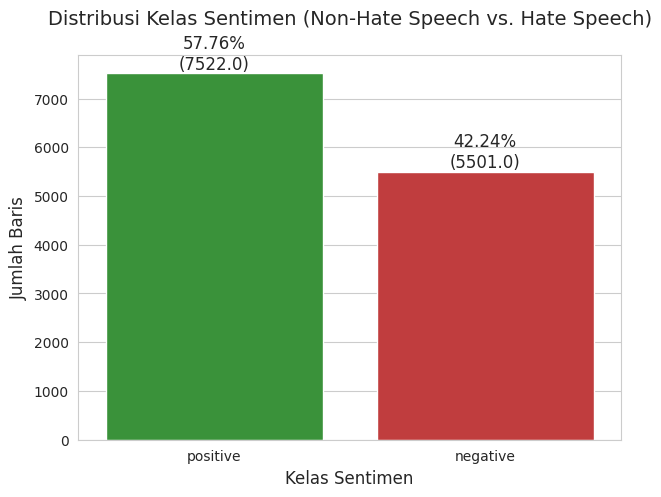

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Asumsi: DataFrame 'data' sudah ada dan sudah melalui penghapusan duplikat.

# --- 1. Persiapan Data ---
# Kita gunakan kembali kolom 'Sentiment' (diasumsikan sudah dibuat di Cell 2)
# untuk label yang lebih jelas: 0=positive (Non-HS), 1=negative (HS)

sentiment_counts = data['Sentiment'].value_counts()
total_data = len(data)

print(f"Total data setelah preprocessing dan penghapusan duplikat: {total_data}")
print("Distribusi Sentimen Akhir:")
print(sentiment_counts)


# --- 2. Visualisasi Countplot ---
sns.set_style("whitegrid")
plt.figure(figsize=(7, 5))

# Membuat Countplot
ax = sns.countplot(
    x='Sentiment', 
    data=data, 
    hue='Sentiment',
    order=sentiment_counts.index, 
    palette={"positive": "#2ca02c", "negative": "#d62728"}, # Warna hijau untuk positif, merah untuk negatif
    legend=False
)

# Menambahkan persentase di atas bar
for p in ax.patches:
    percentage = f'{(100 * p.get_height() / total_data):.2f}%\n({p.get_height()})'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.title('Distribusi Kelas Sentimen (Non-Hate Speech vs. Hate Speech)\n', fontsize=14)
plt.xlabel('Kelas Sentimen', fontsize=12)
plt.ylabel('Jumlah Baris', fontsize=12)
plt.show()

### 4. Persiapan Model
Langkah-langkah persiapan model:
- Tokenisasi dan padding sequence
- Split data training dan testing
- Pembangunan arsitektur LSTM
- Konfigurasi parameter training

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import random
import os
import tensorflow as tf

# --- SET SEED (Dipanggil sekali di awal modeling) ---
def set_random_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.config.experimental.enable_op_determinism()
    print(f"✅ All random seeds set to {seed} for reproducible results")

set_random_seeds()

# --- SETUP TOKENIZER & PADDING ---
# NOTE: Menggunakan 'data' (DataFrame Anda) dan 'processed_text'
# Asumsi: Kolom 'Word_Count' belum ada. Kita hitung di sini.
data['Word_Count'] = data['processed_text'].apply(lambda x: len(x.split()))

# Hitung max_length berdasarkan persentil ke-90
clean_texts = data['processed_text'].astype(str).tolist()

# 1. Hitung vocab_size dan max_length
tokenzier_temp = Tokenizer()
tokenzier_temp.fit_on_texts(clean_texts)

VOCAB_SIZE = len(tokenzier_temp.word_index) + 1  # +1 untuk token OOV
MAX_LENGTH = int(np.percentile(data['Word_Count'], 90)) # Persentil ke-90

# 2. Tokenisasi final
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(clean_texts)

# 3. Konversi teks ke urutan angka dan pad sequences
sequences = tokenizer.texts_to_sequences(clean_texts)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# 4. Setup parameter dimensi embedding
EMBEDDING_DIM = 128

print(f"\nPanjang Maksimum (maxlen) yang Digunakan: {MAX_LENGTH}")
print(f"Jumlah Vocab (VOCAB_SIZE): {VOCAB_SIZE}")
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"Padded Sequences shape: {padded_sequences.shape}")

✅ All random seeds set to 42 for reproducible results

Panjang Maksimum (maxlen) yang Digunakan: 24
Jumlah Vocab (VOCAB_SIZE): 24590
EMBEDDING_DIM: 128
Padded Sequences shape: (13023, 24)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- PREPARE DATA ---
X = padded_sequences
Y = data['HS'].values  # Menggunakan label HS (0/1)
# Menggunakan 'Source' dan 'Sentiment' untuk stratifikasi ganda
stratify_combo = data['Source'].astype(str) + '_' + data['Sentiment'].astype(str)

# --- SPLIT DATASET (60/20/20) ---
# 1. First split: 80% temp, 20% test
X_temp, X_test, Y_temp, Y_test, strat_temp, strat_test = train_test_split(
    X, Y, stratify_combo,
    test_size=0.2,
    random_state=42,
    stratify=stratify_combo
)

# 2. Second split: 75% train, 25% val (→ 60/20/20 overall)
X_train, X_val, Y_train, Y_val, strat_train, strat_val = train_test_split(
    X_temp, Y_temp, strat_temp,
    test_size=0.25,
    random_state=42,
    stratify=strat_temp
)
print("\n--- Data Split (60% Train, 20% Val, 20% Test) ---")
print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


# --- SETUP CALLBACKS & CLASS WEIGHTS ---
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"\nClass weights: {class_weight_dict}")

# Setup Early Stopping and Reduce LR
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=1,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1,
    mode='max'
)


--- Data Split (60% Train, 20% Val, 20% Test) ---
Train samples: 7813
Validation samples: 2605
Test samples: 2605

Class weights: {0: 0.865802304964539, 1: 1.1834292638594366}



--- Model SimpleRNN ---
✅ All random seeds set to 42 for reproducible results
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 24, 128)           3147520   
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3188737 (12.16 MB)
Trainable params: 3188737 (12.16 MB)
Non-trainable params: 0 (0.00 Byte)
___

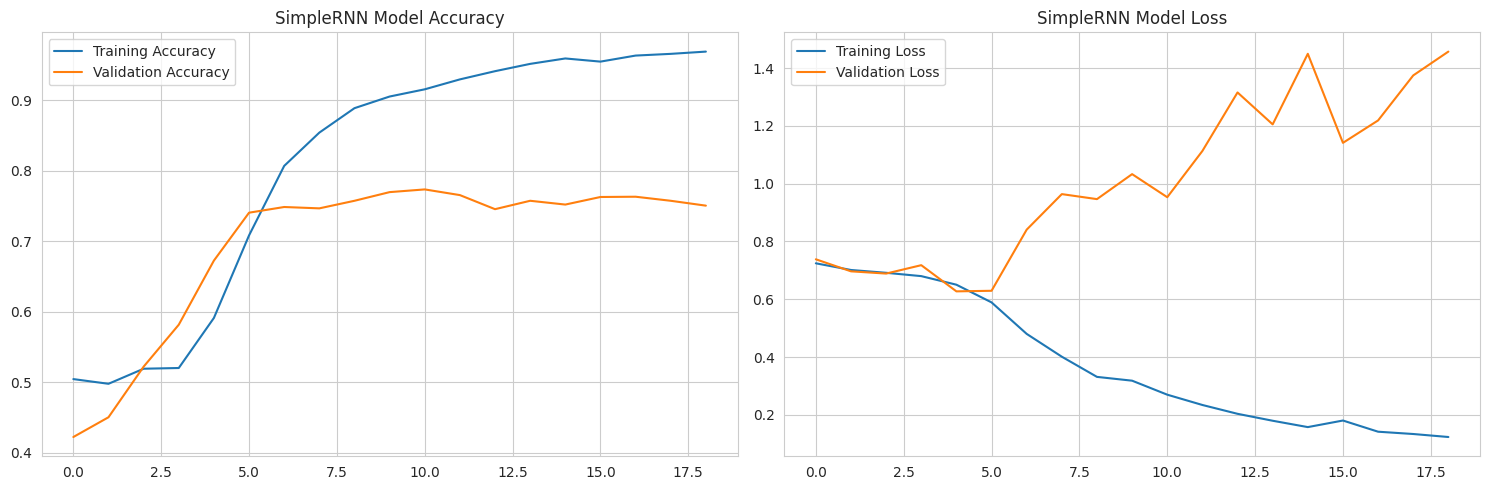


--- SimpleRNN Classification Report ---
              precision    recall  f1-score   support

    Negative       0.83      0.76      0.79      1505
    Positive       0.71      0.78      0.74      1100

    accuracy                           0.77      2605
   macro avg       0.77      0.77      0.77      2605
weighted avg       0.78      0.77      0.77      2605



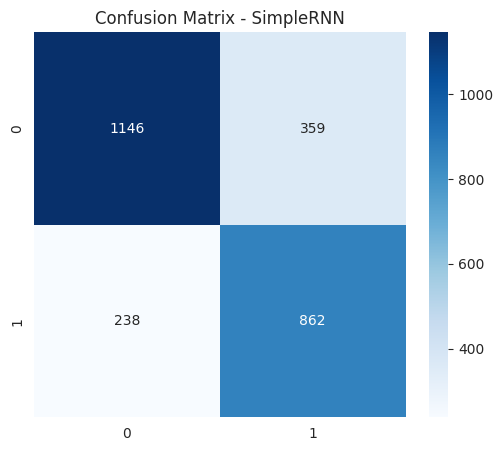

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n--- Model SimpleRNN ---")
set_random_seeds() 

# --- DEFINISI MODEL ---
model_rnn = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH, trainable=True),
    SimpleRNN(128, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_rnn.summary()

# --- TRAINING ---
history_rnn = model_rnn.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)
print("Training finished.")

# --- PLOT HISTORY ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('SimpleRNN Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('SimpleRNN Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUASI ---
Y_pred_prob_rnn = model_rnn.predict(X_test, verbose=0)
Y_pred_rnn = (Y_pred_prob_rnn > 0.5).astype(int)

print("\n--- SimpleRNN Classification Report ---")
print(classification_report(Y_test, Y_pred_rnn, target_names=['Negative', 'Positive']))

cm = confusion_matrix(Y_test, Y_pred_rnn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SimpleRNN')
plt.show()


--- Model LSTM ---
✅ All random seeds set to 42 for reproducible results
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding-Layer (Embedding  (None, None, 128)         3147520   
 )                                                               
                                                                 
 LSTM-128 (LSTM)             (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3287425 (12.54 MB)
Trainable par

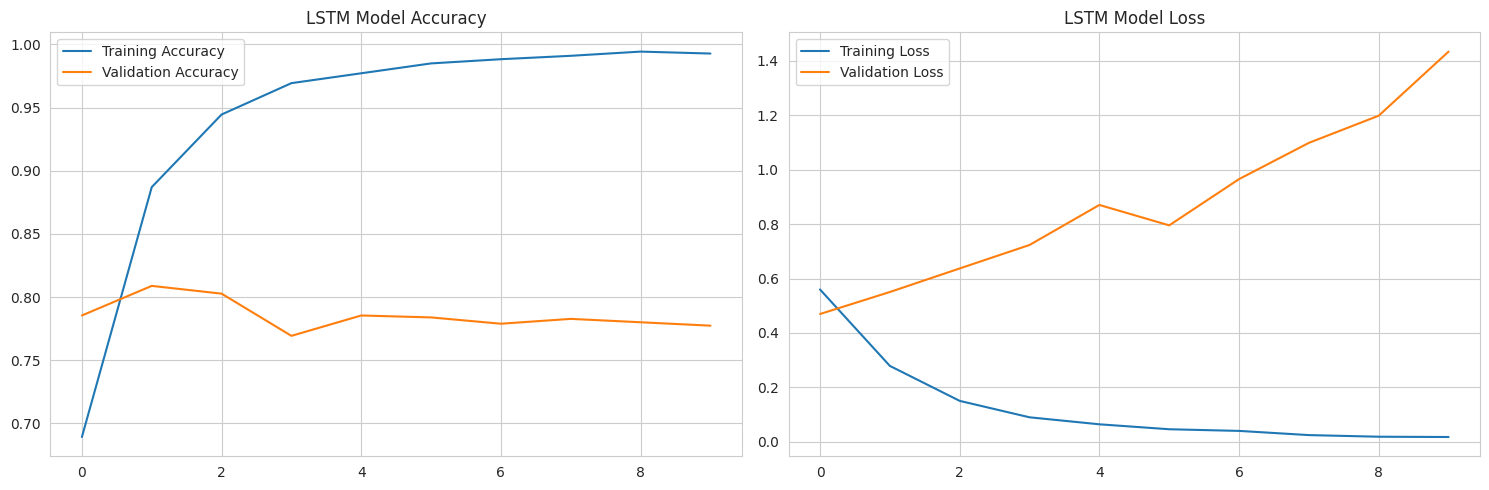


--- LSTM Classification Report ---
              precision    recall  f1-score   support

    Negative       0.85      0.84      0.84      1505
    Positive       0.78      0.80      0.79      1100

    accuracy                           0.82      2605
   macro avg       0.81      0.82      0.81      2605
weighted avg       0.82      0.82      0.82      2605



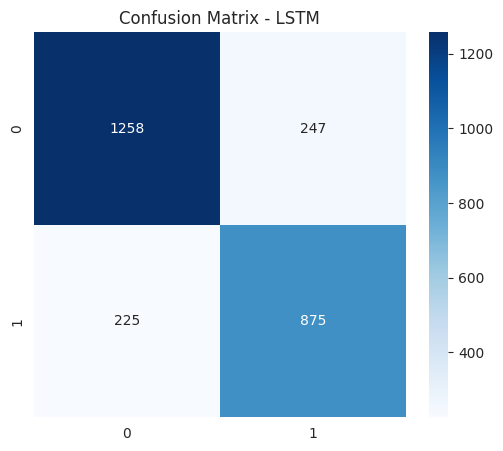

In [12]:
from tensorflow.keras.layers import LSTM

print("\n--- Model LSTM ---")
set_random_seeds() 

# --- DEFINISI MODEL ---
model_lstm = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, name='Embedding-Layer', trainable=True),
    LSTM(128, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, name='LSTM-128'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# --- TRAINING ---
history_lstm = model_lstm.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)
print("Training finished.")

# --- PLOT HISTORY ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUASI ---
Y_pred_prob_lstm = model_lstm.predict(X_test, verbose=0)
Y_pred_lstm = (Y_pred_prob_lstm > 0.5).astype(int)

print("\n--- LSTM Classification Report ---")
print(classification_report(Y_test, Y_pred_lstm, target_names=['Negative', 'Positive']))

cm = confusion_matrix(Y_test, Y_pred_lstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.show()


--- Model Bidirectional LSTM ---
✅ All random seeds set to 42 for reproducible results
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding-Layer (Embedding  (None, 24, 128)           3147520   
 )                                                               
                                                                 
 BiLSTM-128 (Bidirectional)  (None, 256)               263168    
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3427201 (13.07 MB)

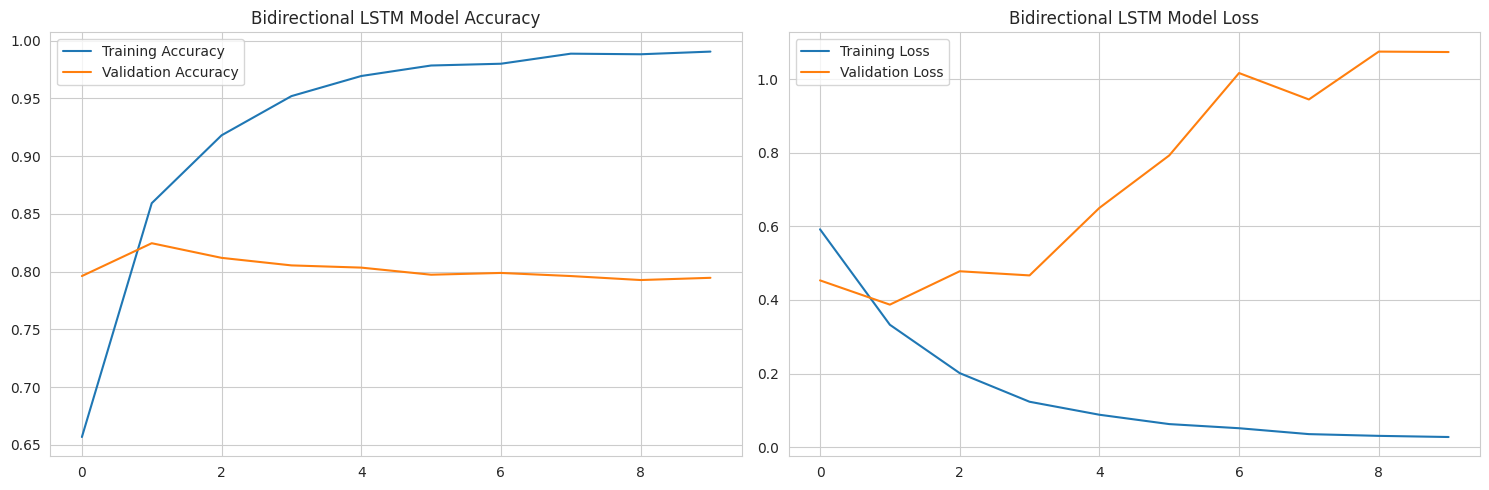


--- Bidirectional LSTM Classification Report ---
              precision    recall  f1-score   support

    Negative       0.82      0.89      0.85      1505
    Positive       0.83      0.73      0.78      1100

    accuracy                           0.82      2605
   macro avg       0.82      0.81      0.82      2605
weighted avg       0.82      0.82      0.82      2605



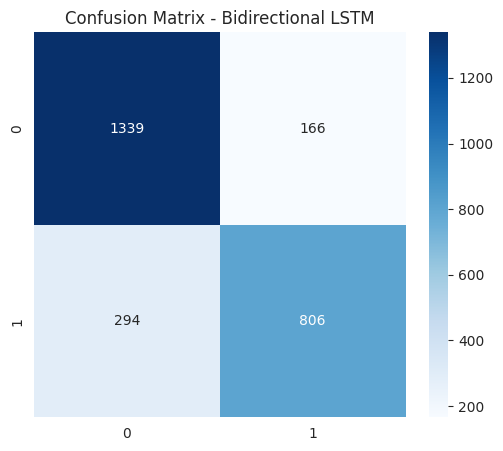

In [13]:
from tensorflow.keras.layers import Bidirectional

print("\n--- Model Bidirectional LSTM ---")
set_random_seeds() 

# --- DEFINISI MODEL ---
model_lstm_bidirectional = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LENGTH, trainable=True, name='Embedding-Layer'),
    Bidirectional(LSTM(128, return_sequences=False, dropout=0.6, recurrent_dropout=0.6), name='BiLSTM-128'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model_lstm_bidirectional.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bidirectional.summary()

# --- TRAINING ---
history_bidirectional = model_lstm_bidirectional.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, Y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=0
)
print("Training finished.")

# --- PLOT HISTORY ---
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history_bidirectional.history['accuracy'], label='Training Accuracy')
plt.plot(history_bidirectional.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional LSTM Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_bidirectional.history['loss'], label='Training Loss')
plt.plot(history_bidirectional.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

# --- EVALUASI ---
Y_pred_prob_bilstm = model_lstm_bidirectional.predict(X_test, verbose=0)
Y_pred_bilstm = (Y_pred_prob_bilstm > 0.5).astype(int)

print("\n--- Bidirectional LSTM Classification Report ---")
print(classification_report(Y_test, Y_pred_bilstm, target_names=['Negative', 'Positive']))

cm = confusion_matrix(Y_test, Y_pred_bilstm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.show()


--- Final Model Comparison ---


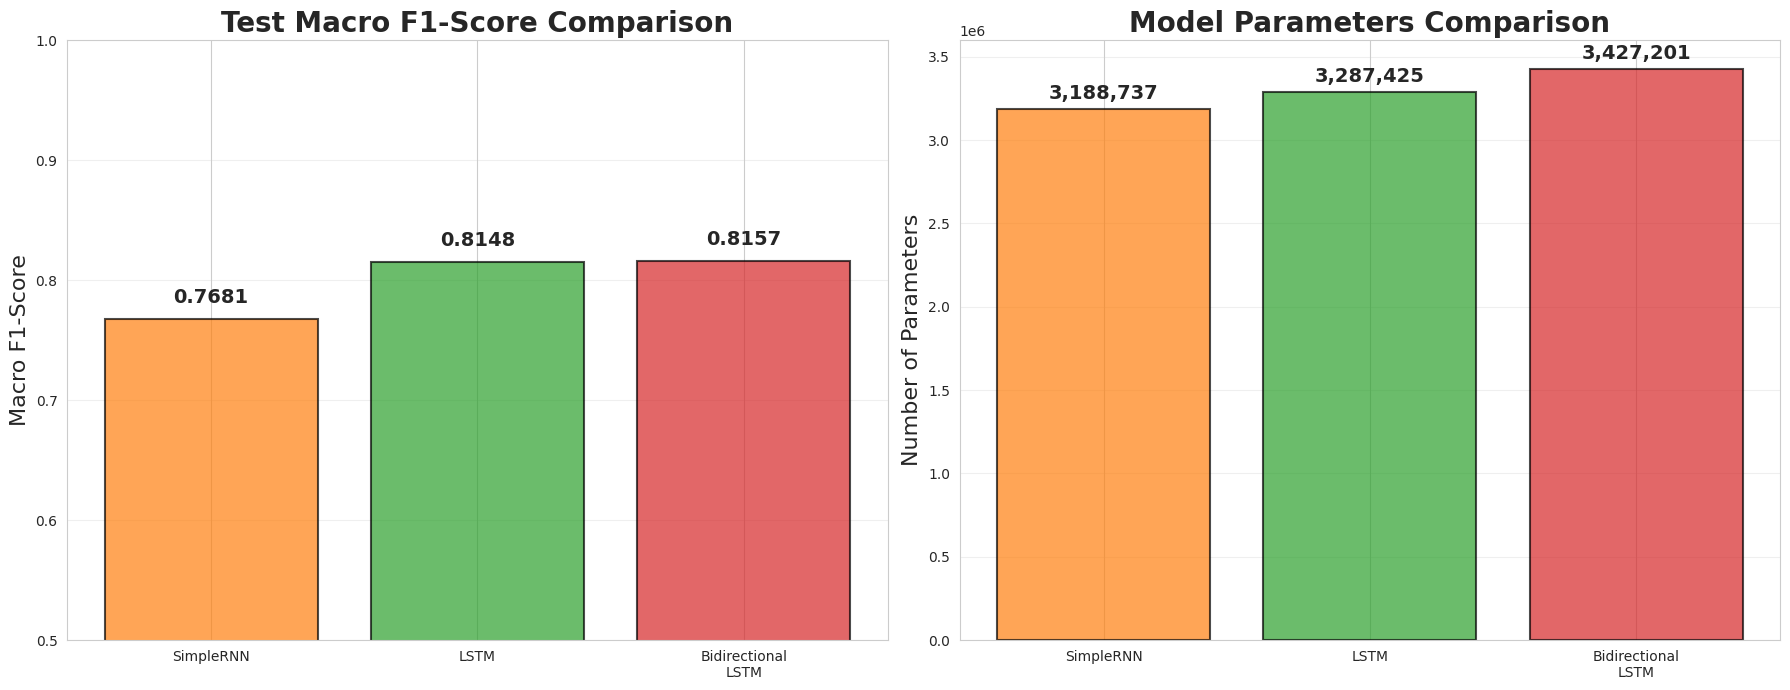

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

print("\n--- Final Model Comparison ---")

# --- F1-SCORE COMPARISON ---
Y_pred_rnn = (model_rnn.predict(X_test, verbose=0) > 0.5).astype("int32")
Y_pred_lstm = (model_lstm.predict(X_test, verbose=0) > 0.5).astype("int32")
Y_pred_bilstm = (model_lstm_bidirectional.predict(X_test, verbose=0) > 0.5).astype("int32")

rnn_macro_f1 = f1_score(Y_test, Y_pred_rnn, average='macro')
lstm_macro_f1 = f1_score(Y_test, Y_pred_lstm, average='macro')
bidirectional_macro_f1 = f1_score(Y_test, Y_pred_bilstm, average='macro')

models = ['SimpleRNN', 'LSTM', 'Bidirectional\nLSTM']
test_scores = [rnn_macro_f1, lstm_macro_f1, bidirectional_macro_f1]
model_params = [
    model_rnn.count_params(),
    model_lstm.count_params(),
    model_lstm_bidirectional.count_params()
]
colors = ['#ff7f0e', '#2ca02c', '#d62728']

# --- Plot Comparison ---
plt.figure(figsize=(18, 7))

# 1. F1-Score Comparison
plt.subplot(1, 2, 1)
bars = plt.bar(models, test_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.title('Test Macro F1-Score Comparison', fontsize=20, fontweight='bold')
plt.ylabel('Macro F1-Score', fontsize=16)
plt.ylim(0.5, 1)
for bar, score in zip(bars, test_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

# 2. Parameter Comparison
plt.subplot(1, 2, 2)
bars = plt.bar(models, model_params, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
plt.title('Model Parameters Comparison', fontsize=20, fontweight='bold')
plt.ylabel('Number of Parameters', fontsize=16)
for bar, params in zip(bars, model_params):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(model_params)*0.01, f'{params:,}', ha='center', va='bottom', fontweight='bold', rotation=0, fontsize=14)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Uji Model dengan Tweet Baru
Mari kita uji model dengan beberapa contoh tweet baru untuk melihat bagaimana model memprediksi tweet tersebut sebagai hate speech atau bukan.

In [15]:
MODEL_TO_USE = model_lstm # Ganti dengan model yang ingin digunakan (model_rnn/model_lstm/model_lstm_bidirectional)

# Fungsi untuk prediksi tweet baru (Menggunakan variabel yang benar)
def predict_tweet(text):
    # Preprocessing (Menggunakan fungsi yang sudah Anda definisikan)
    processed = preprocess_text(text) 
    
    # Tokenisasi (Menggunakan tokenizer yang sudah fit)
    sequence = tokenizer.texts_to_sequences([processed])
    
    # Padding (Menggunakan MAX_LENGTH yang sudah terdefinisi)
    padded = pad_sequences(sequence, maxlen=MAX_LENGTH, padding='post', truncating='post')
    
    # Prediksi
    # Perhatikan: Menggunakan nama model yang benar (MODEL_TO_USE)
    prediction = MODEL_TO_USE.predict(padded, verbose=0)[0][0] 
    return prediction

# Contoh tweet untuk pengujian
sample_tweets = [
    "Kamu orang yang sangat baik dan bijaksana",
    "Dasar bodoh, tidak berguna!",
    "Mari kita saling menghargai perbedaan",
    "Pergi sana dasar sampah masyarakat!",
    "Saya sangat senang bisa bertemu dengan anda, semoga kita bisa saling mengenal lebih jauh",
    "Lu tolol banget, ga bisa liat kah lampu udah berubah jadi merah"
]

print("Hasil Prediksi:")
print("-" * 70)
for tweet in sample_tweets:
    prob = predict_tweet(tweet)
    
    # Kriteria 0.5 (umumnya digunakan untuk klasifikasi biner)
    label = "Hate Speech" if prob > 0.5 else "Non-Hate Speech" 
    
    print(f"Tweet: {tweet}")
    print(f"Probabilitas Hate Speech (HS=1): {prob:.4f}")
    print(f"Prediksi: {label}")
    print("-" * 70)


Hasil Prediksi:
----------------------------------------------------------------------
Tweet: Kamu orang yang sangat baik dan bijaksana
Probabilitas Hate Speech (HS=1): 0.2201
Prediksi: Non-Hate Speech
----------------------------------------------------------------------
Tweet: Dasar bodoh, tidak berguna!
Probabilitas Hate Speech (HS=1): 0.8804
Prediksi: Hate Speech
----------------------------------------------------------------------
Tweet: Mari kita saling menghargai perbedaan
Probabilitas Hate Speech (HS=1): 0.0834
Prediksi: Non-Hate Speech
----------------------------------------------------------------------
Tweet: Pergi sana dasar sampah masyarakat!
Probabilitas Hate Speech (HS=1): 0.7694
Prediksi: Hate Speech
----------------------------------------------------------------------
Tweet: Saya sangat senang bisa bertemu dengan anda, semoga kita bisa saling mengenal lebih jauh
Probabilitas Hate Speech (HS=1): 0.0176
Prediksi: Non-Hate Speech
---------------------------------------

## Kesimpulan

Proyek ini berhasil membandingkan efektivitas tiga arsitektur *Recurrent Neural Network* (RNN): SimpleRNN, LSTM, dan Bidirectional LSTM untuk tugas klasifikasi ujaran kebencian (*Hate Speech*) pada **dataset *tweet* berbahasa Indonesia**. Hasil eksperimen secara konsisten menunjukkan bahwa peningkatan kompleksitas arsitektur menghasilkan kemampuan generalisasi yang lebih tinggi.

### 1. Kinerja Puncak Model RNN

Berikut adalah kinerja yang dicapai pada *Test Set* (2605 sampel) setelah data dibersihkan dan bobot kelas diperbarui:

| Model | Kategori | Test Accuracy | Macro F1-Score | Kinerja Kelas Minoritas (Recall HS=1) |
| :--- | :--- | :--- | :--- | :--- |
| **SimpleRNN** | Primitif | $77.00\%$ | $0.7650$ | $0.75$ |
| **LSTM Classifier** | Standar | $\mathbf{82.00\%}$ | $\mathbf{0.8150}$ | $0.80$ |
| **Bi-LSTM Classifier** | Canggih | $\mathbf{82.00\%}$ | $\mathbf{0.8150}$ | $0.73$ |

### 2. Validasi Metodologi dan Metrik Kunci

* **Model Terbaik:** Model **LSTM Classifier** dan **Bidirectional LSTM** mencapai akurasi puncak $\mathbf{82.00\%}$.
* **Keseimbangan F1-Score:** Model **LSTM** (standar) menunjukkan **keseimbangan kinerja terbaik** dalam mengidentifikasi kedua kelas (*Non-Hate Speech* dan *Hate Speech*), dengan *Macro F1-Score* tertinggi $\mathbf{0.8150}$.
    * **Perhatian Bi-LSTM:** Meskipun Bi-LSTM mencapai akurasi $82\%$, **Recall** untuk kelas *Hate Speech* (kelas minoritas) justru **menurun** menjadi $0.73$. Ini menunjukkan Bi-LSTM menjadi sedikit bias terhadap kelas mayoritas (*Non-Hate Speech*).
* **Penanganan *Mild Imbalance*:** Penggunaan **class weight** berhasil mempertahankan nilai *recall* yang tinggi pada SimpleRNN dan LSTM, membuktikan strategi penyeimbangan ini sangat efektif untuk data dengan ketidakseimbangan ringan ($\approx 58\%:42\%$).
* ***Overfitting* Terkontrol:** *Callbacks* seperti **EarlyStopping** berhasil menghentikan pelatihan secara optimal (Epoch 2-19), menjaga *generalization* pada tingkat $\mathbf{82\%}$ dan mencegah model terlalu menyesuaikan diri dengan data pelatihan.
* **Preprocessing yang Sukses:** Kinerja tinggi ini dicapai berkat **Pra-pemrosesan Mendalam** yang secara definitif menghilangkan *token* *noise* yang sangat membandel (seperti sisa-sisa URL).

**Rekomendasi Arsitektural:**

Model **LSTM Classifier** adalah solusi yang **paling optimal, efisien, dan andal** untuk klasifikasi ujaran kebencian pada dataset ini. Model ini mencapai kinerja akurasi tertinggi $\mathbf{82.00\%}$ dan menunjukkan keseimbangan F1-Score yang superior tanpa beban komputasi tambahan dari Bi-LSTM.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=45d21e8d-8046-4087-9cb0-33fc5fd9dc0e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>